# Obligatorisk innlevering 2 - oppgave 1

Denne oppgaven tar for seg et datasett fra Food Mart, som er en nærbutikkjede i USA. Food Mart har i dette datasettet samlet endel data i forbindelse med mediekampanjer. Din oppgave er å forutsi kostnadene for mediekampanjer i matvaremarkedet på grunnlag av funksjonene som tilbys.

In [1]:
# Importer resten av pakkene du trenger her:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [2]:
# I denne oppgaven skal dere bruke følgende datasett:
df = pd.read_csv("./datasett1.csv")
# Her deler jeg datasettet inn i egenskaper (X) og target (y)
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
# Tilslutt deler jeg inn i et trening- og et testsett (75%/25%)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)
# PS: Ikke endre denne kodecellen!

In [3]:
# Lagt inn mer forklaring til koden ovenfor - hentet fra ChatGPT
# Her deler jeg datasettet inn i egenskaper (features) (X) 
# og target (the cost - i dette tilfelle kostnad av mediekampanjer) (y)

# This line extracts the input variables (features) from the DataFrame df. 
# It uses the .iloc method to select all rows and all columns except the last one (specified by [:-1]). 
# The input variables are typically the independent variables used to make predictions.
#X = df.iloc[:,:-1]

#This line extracts the target variable (cost) from the DataFrame df. 
# It uses .iloc to select all rows and only the last column (specified by [:,-1]). 
# The target variable is the dependent variable that you want to predict.
#y = df.iloc[:,-1]

# Tilslutt deler jeg inn i et trening- og et testsett (75%/25%)
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)

#### Oppgave 1.1) 
Visualiser $y\_train$ og $y\_test$ i et histogram. Kan du, basert på figuren, se hva slags problem vi skal løse (regresjon/klassifisering)? 

Begrunn svaret

In [4]:
df.head() #Se på hva datasettet inneholder, mest kontinuerlige numeriske verdier og noen boolske 0/1 verdier

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,2.68,2.0,1.0,0.0,2.0,6.30,1.0,0.0,22.0,30584.0,1.0,1.0,1.0,1.0,1.0,79.59
1,5.73,3.0,5.0,5.0,3.0,18.70,1.0,0.0,30.0,20319.0,0.0,0.0,0.0,0.0,0.0,118.36
2,2.62,2.0,1.0,1.0,1.0,9.21,0.0,0.0,9.0,20319.0,0.0,0.0,0.0,0.0,0.0,67.20
3,11.73,3.0,1.0,1.0,3.0,10.90,1.0,1.0,15.0,23112.0,1.0,1.0,1.0,1.0,1.0,60.87
4,4.82,2.0,1.0,1.0,3.0,8.15,0.0,0.0,7.0,38382.0,0.0,0.0,0.0,0.0,0.0,86.79


In [5]:
df #51363 rows × 16 columns

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,2.68,2.0,1.0,0.0,2.0,6.30,1.0,0.0,22.0,30584.0,1.0,1.0,1.0,1.0,1.0,79.59
1,5.73,3.0,5.0,5.0,3.0,18.70,1.0,0.0,30.0,20319.0,0.0,0.0,0.0,0.0,0.0,118.36
2,2.62,2.0,1.0,1.0,1.0,9.21,0.0,0.0,9.0,20319.0,0.0,0.0,0.0,0.0,0.0,67.20
3,11.73,3.0,1.0,1.0,3.0,10.90,1.0,1.0,15.0,23112.0,1.0,1.0,1.0,1.0,1.0,60.87
4,4.82,2.0,1.0,1.0,3.0,8.15,0.0,0.0,7.0,38382.0,0.0,0.0,0.0,0.0,0.0,86.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51358,3.70,2.0,4.0,4.0,1.0,10.40,1.0,1.0,18.0,34452.0,1.0,0.0,0.0,0.0,1.0,147.17
51359,10.36,4.0,2.0,0.0,2.0,9.43,0.0,0.0,20.0,30797.0,1.0,1.0,1.0,1.0,1.0,92.57
51360,11.19,3.0,3.0,0.0,3.0,18.50,0.0,0.0,5.0,30797.0,1.0,1.0,1.0,1.0,1.0,92.57
51361,3.78,3.0,1.0,1.0,2.0,19.80,0.0,1.0,8.0,23598.0,0.0,0.0,0.0,0.0,1.0,135.92


In [6]:
# Kode fra ChatGPT 3.5
# Calculate statistics for the 'Column_Name' column
mean = df['cost'].mean()
maximum = df['cost'].max()
minimum = df['cost'].min()
median = df['cost'].median()

print("Mean:", mean)
print("Max:", maximum)
print("Min:", minimum)
print("Median:", median)

Mean: 99.32706442380702
Max: 149.75
Min: 50.79
Median: 98.52


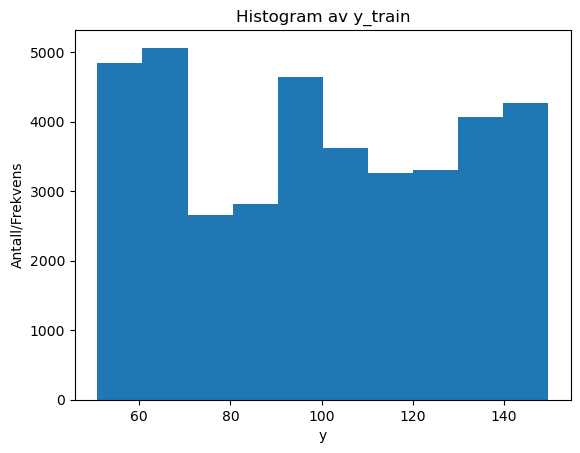

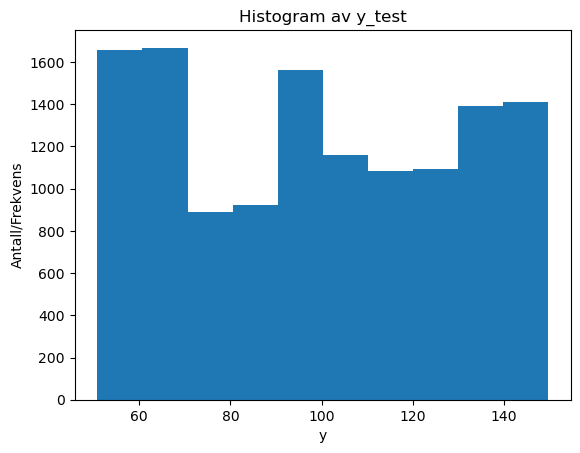

In [7]:
#TODO: visualiser y_train og y_test i et histogram
# y_train
plt.hist(y_train)
plt.title("Histogram av y_train")
plt.ylabel(r'Antall/Frekvens')
plt.xlabel(r'y')
plt.show()

# y_test
plt.hist(y_test)
plt.title("Histogram av y_test")
plt.ylabel(r'Antall/Frekvens')
plt.xlabel(r'y')
plt.show()


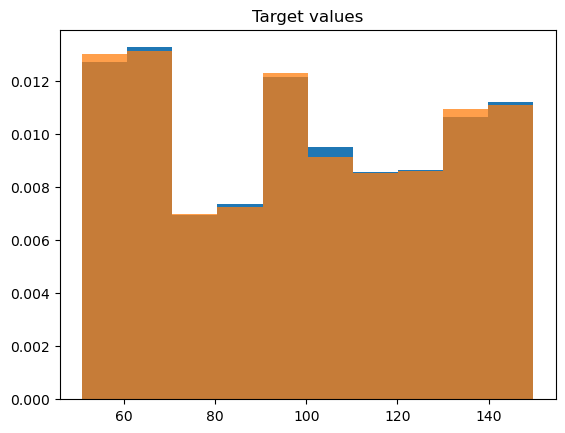

In [8]:
# Kode fra forelesning 1 - viser at test og train verdiene er likt distribuert
plt.title("Target values")
plt.hist(y_train, density=True, color="C0", label="train")
plt.hist(y_test, density=True, color="C1", alpha=0.75, label="val")
plt.show()

**Svar:**

Dette er ett regresjons problem. Vi skal prøve å forutsi en kontinuerlig verdi y (som i dette tilfellet er kostnadene for mediekampanjer) - dvs variabelen cost basert på de andre input variablene i datasettet (X).
Klassifikasjon problemer løser problemer av type spørsmål: ja/nei, solgt/ikke solgt, hund/katt.

Ved å se på de 2 historgrammene ser vi at vi har "kontinuerlige" tall verdier - som i histogrammene er delt inn i 10 grupper (bins). Vi ser at target verdien cost er ganske uniformt distribuert og at test og trene settene er veldig like.

#### Oppgave 1.2) 

fullfør funksjonen under slik at den tar inn både egenskapene og target, legger disse sammen i samme matrise igjen og visualiser dataene som en korrelasjonsmatrise (poenget er at du skal kunne se hvordan egenskapene korrelerer med target).

* Beskriv hvilke egenskaper du ser korrelerer mest med target

In [9]:
# Kode fra forelesning 1 - 05
def plot_correlation_matrix(X,y):
    X_copy = X.copy()
    X_copy["target"] = y
    plt.figure(figsize=(15,10))
    sns.heatmap(X_copy.corr(), annot=True) #TODO: mask halve matrisen
    plt.show()

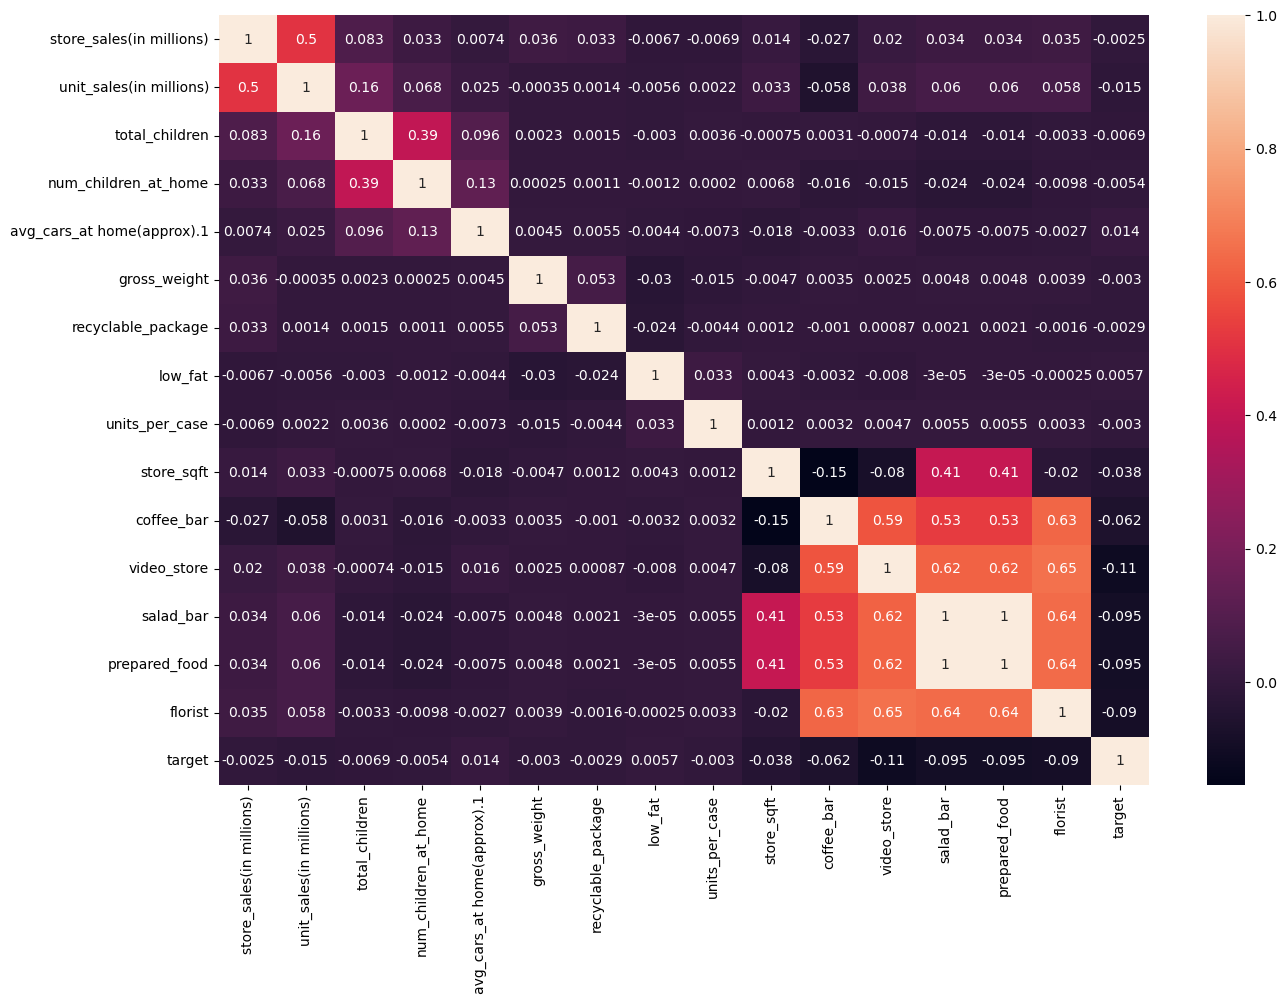

In [10]:
plot_correlation_matrix(X,y)

In [11]:
def korrelasjonsmatrise(X,y):
    X_temp = X.copy()
    y_temp = y.copy()
    X_temp["Target"] = y_temp
    return X_temp

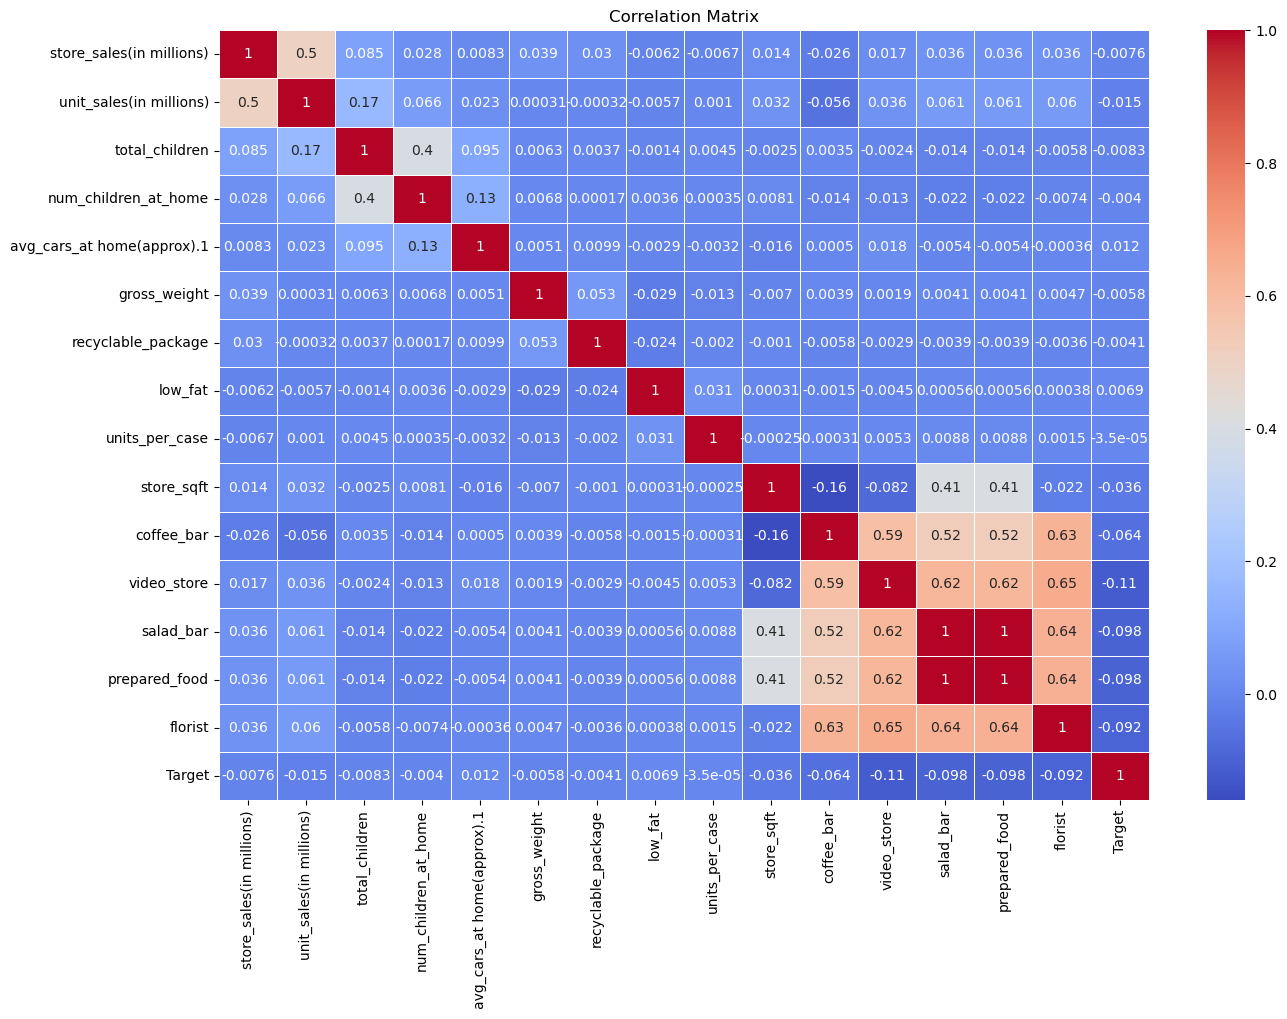

In [12]:
# Kode fra ChatGPT 3.5
# Samme korrelasjonsmatrise fått med seaborn
X_temp = korrelasjonsmatrise(X_train,y_train)
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
sns.heatmap(X_temp.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()


**Svar:**
Det er ingen egenskaper jeg ser som korrelerer med target, men det er andre egenskaper som korrelerer med hverandre i litt varierende grad utifra korrelasjonsmatrisen. Verdier mellom: 0,65-0,52.

Egenskaper som:

florist - prepared_food

florist - salad_bar

florist - video_store

florist - coffee_bar

prepared_food - coffe_bar/video_store

video_store - salad_bar

coffee_bar - video_store/salad_bar/prepared food


#### Oppgave 1.3) 
Velg en modellarkitektur (gjerne fra Scikit-Learn) og gjør et strukturert hyperparametersøk. 
* Gjør et søk på minst 3 parametere og minst 2 verdier pr parameter
* Bruk 3-folds kryssvalidering for hver parameterkombinasjon
* Velg en metrikk som passer for målet (tips: "neg_mean_squared_error" i sklearn) 
* Skriv ut den parameterkobinasjonen som ga den beste skåren, samt skåren. Kommenter resultatet

In [39]:
%%time
#TODO: Utfør hyperparametersøk for en modell
# Kode fra ChatGPT 3.5
# 3-folds kryssvalidering = train sett er splittet i 3 mindre sett - crioss_val_score

# Model 1 - Random Forest Regressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


# Create the Random Forest Regressor
rf_model = RandomForestRegressor()

# Define hyperparameter grid for hyperparameter search
param_grid_rf = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'max_depth': [None, 5, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'random_state': [42],  # Seed for random number generation for reproducibility
    'n_jobs': [-1],  # Number of jobs to run in parallel (set to -1 to use all available processors)
}

# Create a GridSearchCV object
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=3)

# Fit the model
grid_search_rf.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params_rf = grid_search_rf.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params_rf)

Best Parameters: RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=200,
                      n_jobs=-1, random_state=42)
CPU times: total: 1min 15s
Wall time: 2min 19s


In [42]:
%%time

# Kode fra ChatGPT 3.5
# Perform 3-fold cross-validation for the best Random Forest model
rf_mse_scores = cross_val_score(best_params_rf, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
#rf_r2_scores = cross_val_score(best_params_rf, X_train, y_train, cv=3, scoring='r2')
#rf_mae_scores = cross_val_score(best_params_rf, X_train, y_train, cv=3, scoring='neg_mean_absolute_error')

# Convert negative MSE and MAE scores to positive values
mse_scores = -rf_mse_scores
mae_scores = -rf_mae_scores

# Calculate the mean and standard deviation of each metric
mean_mse_rf = mse_scores.mean()
std_mse_rf = mse_scores.std()

#mean_r2_rf = rf_r2_scores.mean()
#std_r2_rf = rf_r2_scores.std()

#mean_mae_rf = mae_scores.mean()
#std_mae_rf = mae_scores.std()

print("Random Forest Regressor Metrics (3-fold CV):")
print(f"Mean MSE: {mean_mse_rf:.2f}")
print(f"MSE Standard Deviation: {std_mse_rf:.2f}")

#print(f"Mean R2-score: {mean_r2_rf:.2f}")
#print(f"R2-score Standard Deviation: {std_r2_rf:.2f}")

#print(f"Mean MAE: {mean_mae_rf:.2f}")
#print(f"MAE Standard Deviation: {std_mae_rf:.2f}")

Random Forest Regressor Metrics (3-fold CV):
Mean MSE: 850.77
MSE Standard Deviation: 9.23
CPU times: total: 2.11 s
Wall time: 5.29 s


**Svar:**

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

Etter min tolkning av diagram ovenfor er det en regression model fra Scikit-learn jeg burde bruke. 
Jeg har brukt ChatGPT til å spørre hvilken modell som er lur å bruke, jeg fikk 2 alternativ:

Random Forest Regressor og GradientBoostingRegressor.
GradientBoostingRegressor bruke mye lengre tid for å gjennomføre så jeg har gått med Random Forest Regressor.

##### Beste parameter kombinasjon:

RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=200,
                      n_jobs=-1, random_state=42)

CPU times: total: 1min 15s

Wall time: 2min 19s

Mean: The mean cost value is approximately 99.33. This provides an idea of the central tendency of your target variable. An MSE of 851.47 means that, on average, your model's predictions have an error of approximately √851.47 ≈ 29.19 units from the actual cost.


##### Score

Random Forest Regressor Metrics (3-fold CV)

Mean MSE: 850.77

MSE Standard Deviation: 9.23

##### Tolking

MSE - er gjennomsnittlig forskjell mellom predikert verdi og faktisk verdi. Det betyr at √851.47 ≈ 29.19 at modellens predikasjone er gjennomsnittlig 29.19 enheter fra den faktiske target cost.

MSE Standard Deviation: 9.23 - den er ganske lav, det betyr at modellen er konsistent i de forskjellige delte "foldsene", dvs 3 folds her.

##### Jeg har også prøvd Lasso, som ga lignende resultater.

Best Parameters: {'alphas': [0.01, 0.1, 1]}

Best Negative Mean Squared Error: -886.6483792021563

MSE Standard Deviation: 7.929098095038428

Square Root of MSE: 29.78

In [45]:
# Kode fra ChatGPT 3.5

from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV

# Define the Lasso model
lasso_model = LassoCV(cv=3)  # 3-fold cross-validation during hyperparameter search

# Define hyperparameter grid for hyperparameter search
param_grid_lasso = {
    'alphas': [[0.1, 1, 10], [0.01, 0.1, 1]]  # Two values for each of the three alphas
}

# Create a GridSearchCV object
grid_search_lasso = GridSearchCV(lasso_model, param_grid_lasso, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model
grid_search_lasso.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params_lasso = grid_search_lasso.best_params_
best_lasso_model = grid_search_lasso.best_estimator_

# Print the best parameters, best score, standard deviation, and square root of MSE
best_mse = -grid_search_lasso.best_score_
print("Best Parameters:", best_params_lasso)
print("Best Negative Mean Squared Error:", grid_search_lasso.best_score_)
print("MSE Standard Deviation:", grid_search_lasso.cv_results_['std_test_score'][grid_search_lasso.best_index_])
print("Square Root of MSE:", round((best_mse ** 0.5), 2))


Best Parameters: {'alphas': [0.01, 0.1, 1]}
Best Negative Mean Squared Error: -886.6483792021563
MSE Standard Deviation: 7.929098095038428
Square Root of MSE: 29.78


#### Oppgave 1.4) 
Bruk hyperparameterkombinasjonen fra oppgave 1.3 og kryssvalider den modellen på nytt med K >= 5 
* Logg "mean absolute error" og "mean squared error" for hver kryssvalideringsrunde
* Oppgi gjennomsnitt og standardavvik for "mean absolute error" og "mean squared error" etter kryssvalideringen og kommenter resultatet
* Hvor stor er den gjennomsnittlige feilen på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i treningsdataene? 

In [49]:
%%time
#TODO: Utfør hyperparametersøk for en modell
#TODO: Beregn gjennomsnitt og standard avvik for mean_absolute_error og mean_squared_error og beregn hvor stor den 
#      gjennomsnittlige feilen er i forhold til den gjennomsnittlige prisen for markedskampanjen (target) i prosent

# Kode fra ChatGPT 3.5
# 5-folds kryssvalidering 

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
import numpy as np

# Create the Random Forest Regressor
rf_model = RandomForestRegressor()

# Define hyperparameter grid for hyperparameter search
param_grid_rf = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'max_depth': [None, 5, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'random_state': [42],  # Seed for random number generation for reproducibility
    'n_jobs': [-1],  # Number of jobs to run in parallel (set to -1 to use all available processors)
}

# Create a GridSearchCV object
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5)

# Fit the model
grid_search_rf.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params_rf = grid_search_rf.best_estimator_

# Perform cross-validation and log MAE and MSE for each fold
kf = KFold(n_splits=5, shuffle=True, random_state=0)
mae_scores_rf = -cross_val_score(grid_search_rf.best_estimator_, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
mse_scores_rf = -cross_val_score(grid_search_rf.best_estimator_, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

# Print MAE and MSE for each fold
for fold, (mae, mse) in enumerate(zip(mae_scores_rf, mse_scores_rf), 1):
    print(f"Fold {fold}: MAE = {mae}, MSE = {mse}")

# Calculate and print the mean and standard deviation for both MAE and MSE
mean_mae_rf = np.mean(mae_scores_rf)
std_mae_rf = np.std(mae_scores_rf)
mean_mse_rf = np.mean(mse_scores_rf)
std_mse_rf = np.std(mse_scores_rf)

# Calculate the average target value
average_target_value = np.mean(y_train)

# Express the average error as a percentage of the average target value
average_error_percentage_mae = (mean_mae_rf / average_target_value) * 100
average_error_percentage_mse = (np.sqrt(mean_mse_rf) / average_target_value) * 100

# Print the results
print("\nRandom Forest Regressor - Mean Absolute Error (MAE) - Mean and Standard Deviation:")
print(f"Mean: {mean_mae_rf}")
print(f"Standard Deviation: {std_mae_rf}")
print(f"Average Error Percentage: {average_error_percentage_mae:.2f}%")

print("\nRandom Forest Regressor - Mean Squared Error (MSE) - Mean and Standard Deviation:")
print(f"Mean: {mean_mse_rf}")
print(f"Standard Deviation: {std_mse_rf}")
print(f"Average Error Percentage: {average_error_percentage_mse:.2f}%")




Fold 1: MAE = 25.11315346473641, MSE = 846.3210229217144
Fold 2: MAE = 25.055777288783197, MSE = 845.0537363186927
Fold 3: MAE = 24.957487877902846, MSE = 846.4730544990754
Fold 4: MAE = 25.095130552003813, MSE = 851.8896230330374
Fold 5: MAE = 25.110394527345637, MSE = 851.6116871134776

Random Forest Regressor - Mean Absolute Error (MAE) - Mean and Standard Deviation:
Mean: 25.06638874215438
Standard Deviation: 0.058174807639173196
Average Error Percentage: 25.23%

Random Forest Regressor - Mean Squared Error (MSE) - Mean and Standard Deviation:
Mean: 848.2698247771993
Standard Deviation: 2.885842004158734
Average Error Percentage: 29.32%
CPU times: total: 2min 20s
Wall time: 6min 26s


**Svar:**

MSE - er gjennomsnittlig forskjell mellom predikert verdi og faktisk verdi. Det betyr at √848.27 ≈ 29.12 at modellens predikasjone er gjennomsnittlig 29.12 enheter fra den faktiske target cost. Det er litt bedre resultater enn med 3-Fold.

MSE Standard Deviation: 2.88 - den er ganske lav, det betyr at modellen er konsistent i de forskjellige delte "foldsene", dvs 5 folds her. Her fikk jeg bedre resultat enn 3-folds som var 9.23.

Gjennomsnittlig feil var 25,23 % for MAE og 29,32% for MSE.

#### Oppgave 1.5) 
Tren modellen en siste gang på alle treningsdataene og gjør prediksjon på testdataene (bruk de optimale parametrene fra oppgave 1.3)
* Hvor stor er den gjennomsnittlige feilen på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i testdataene? 

In [51]:
#TODO: Tren modellen på alle treningsdata og utfør prediksjon på testdataene
# Kode fra ChatGPT 3.5
# 5-folds kryssvalidering 

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import numpy as np

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Create the Random Forest Regressor
rf_model = RandomForestRegressor()

# Define hyperparameter grid for hyperparameter search
param_grid_rf = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'max_depth': [None, 5, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'random_state': [42],  # Seed for random number generation for reproducibility
    'n_jobs': [-1],  # Number of jobs to run in parallel (set to -1 to use all available processors)
}

# Create a GridSearchCV object
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5)

# Fit the model on the entire training data
grid_search_rf.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params_rf = grid_search_rf.best_estimator_

# Make predictions on the test data
y_pred_rf = best_params_rf.predict(X_test)

# Calculate and print the mean absolute error and mean squared error on the test data
mae_test = mean_absolute_error(y_test, y_pred_rf)
mse_test = mean_squared_error(y_test, y_pred_rf)

# Calculate the average target value in the test data
average_actual_cost = np.mean(y_test)

# Calculate the average error on the prediction compared to the average actual "cost" target
average_error_percentage_test = (mae_test / average_actual_cost) * 100

print("\nRandom Forest Regressor - Test Data Metrics:")
print(f"Mean Absolute Error (MAE) on Test Data: {mae_test}")
print(f"Mean Squared Error (MSE) on Test Data: {mse_test}")
print(f"Average Error Percentage on Test Data: {average_error_percentage_test:.2f}%")


Random Forest Regressor - Test Data Metrics:
Mean Absolute Error (MAE) on Test Data: 25.12345525197343
Mean Squared Error (MSE) on Test Data: 848.7799684161728
Average Error Percentage on Test Data: 25.30%


**Svar:**

Random Forest Regressor - Test Data Metrics:

Mean Absolute Error (MAE) on Test Data: 25.12345525197343

Mean Squared Error (MSE) on Test Data: 848.7799684161728

Average Error Percentage on Test Data: 25.30%

Dette ligner på det jeg fikk ovenfor.

Gjennomsnittlig feil var 25,30%